# Measuring the coefficient of drag of a pickleball

## imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions

In [ ]:
from dataclasses import dataclass

@dataclass
class Pickleball:
    """Pickleball properties"""
    mass_g: float  # grams
    radius_in: float  # inches
    
    @property
    def mass_lb(self):
        return self.mass_g / 453.592
    
    @property
    def area_ft2(self):
        return np.pi * (self.radius_in / 12)**2


@dataclass
class Environment:
    """Environmental conditions"""
    g_ft_s2: float = 32.174  # gravitational acceleration
    rho_lb_ft3: float = 0.0765  # air density at sea level, STP

## Data location

In [ ]:
freefall_data_path = "../data/freefall.csv"


## Load raw data from CSV file

In [ ]:
df = pd.read_csv(freefall_data_path)

In [ ]:
df.describe()

,frame,time,radius,x,y,vx,vy,ax,ay
count,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,25.000000,25.000000
mean,49.000000,850.850000,1.540433,2.160237,3.240764,-0.484932,13.483465,0.330882,28.831112
std,7.937254,132.419853,0.033956,0.065991,1.804028,0.267823,3.759436,25.859818,16.175229
min,36.000000,633.966667,1.470029,2.042411,0.760117,-0.944153,7.250778,-54.322192,2.653907
25%,42.500000,742.408333,1.520720,2.108433,1.696794,-0.705308,10.526803,-16.347235,20.960772
50%,49.000000,850.850000,1.546065,2.171664,2.990483,-0.489810,13.690601,0.947162,27.672888
75%,55.500000,959.291667,1.558738,2.213949,4.633754,-0.347074,16.472634,15.939191,40.585791
max,62.000000,1067.733333,1.622101,2.252759,6.608795,0.146134,19.275754,41.095267,57.712524


## Notes about the data
- frame: The frame number from the original video. A subset of the frames were selected for trajectory to catch start and end
- time: Currently in milliseconds - as read using cv for each frame.
- radius: Radius of the ball in inces as determined from ball detection. It tends to grow as the speed increases.
- x: displacement horizontally in feet
- y: displacement vertically in feet
- vx, vy, ax, ay - first and second "derivatives". Not very reliable because measurement errors get "compounded"

<Axes: xlabel='time'>

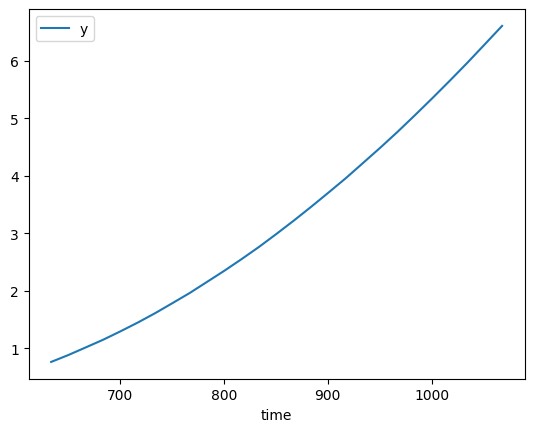

In [ ]:
df.plot(x='time', y='y')

<Axes: xlabel='time'>

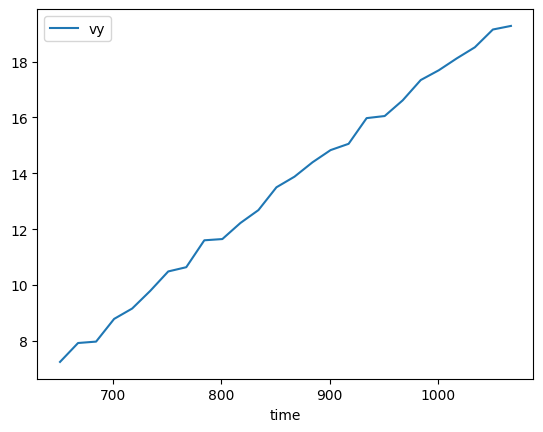

In [ ]:
df.plot(x='time', y='vy')

<Axes: xlabel='time'>

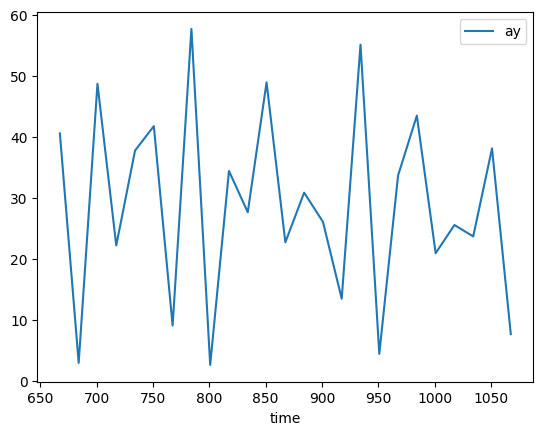

In [ ]:
df.plot(x='time', y='ay')

<Axes: xlabel='time'>

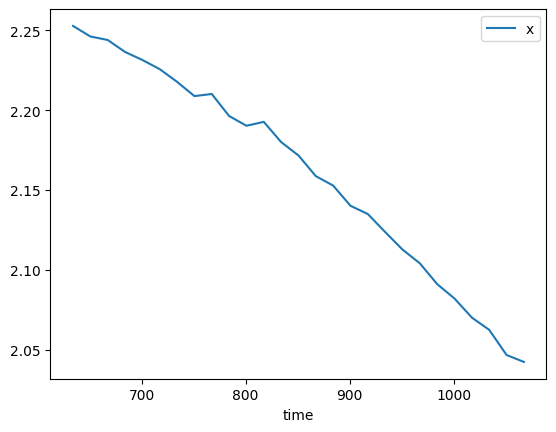

In [ ]:
df.plot(x='time', y='x')

## Quick look at the characteristics of the trajectory. 
Note how the primary data looks fairly clean, but the derived has multiplied measurement uncertainty.

<Axes: xlabel='time'>

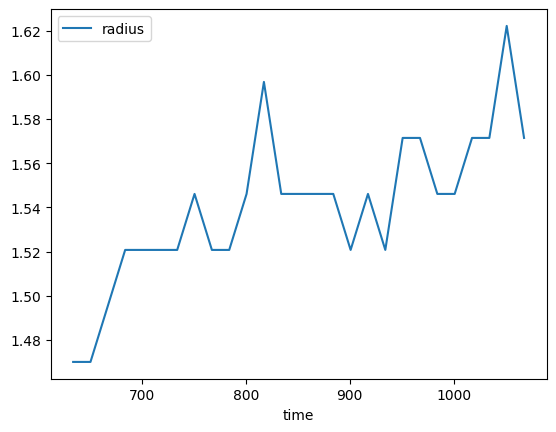

In [ ]:
df.plot(x='time', y='radius')

## The ball radius was calculated from the image
**It tends to grow as the speed increases due to motion blur**

It is a bit fuzzy anyway due to lighting and other normal photographic factors.

In [ ]:
df.describe()

,frame,time,radius,x,y,vx,vy,ax,ay
count,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,25.000000,25.000000
mean,49.000000,850.850000,1.540433,2.160237,3.240764,-0.484932,13.483465,0.330882,28.831112
std,7.937254,132.419853,0.033956,0.065991,1.804028,0.267823,3.759436,25.859818,16.175229
min,36.000000,633.966667,1.470029,2.042411,0.760117,-0.944153,7.250778,-54.322192,2.653907
25%,42.500000,742.408333,1.520720,2.108433,1.696794,-0.705308,10.526803,-16.347235,20.960772
50%,49.000000,850.850000,1.546065,2.171664,2.990483,-0.489810,13.690601,0.947162,27.672888
75%,55.500000,959.291667,1.558738,2.213949,4.633754,-0.347074,16.472634,15.939191,40.585791
max,62.000000,1067.733333,1.622101,2.252759,6.608795,0.146134,19.275754,41.095267,57.712524


<Axes: >

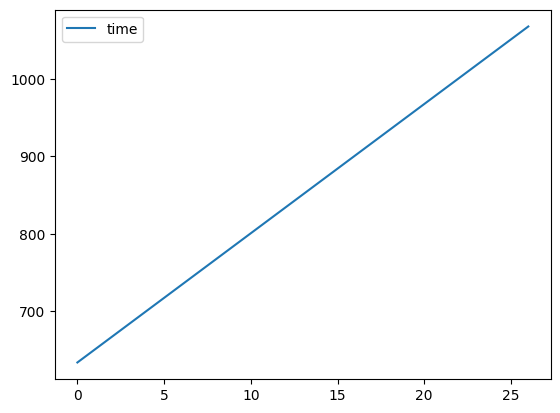

In [ ]:
df.plot(y='time')

**This graph just shows that the time-stamps from the camera are uniformly separated.**

No surprise. Included here because we use the actual elapsed time. We don't **compute** it from frames per second.

In this notebook, our goal is to try to measure the coefficient of drag (CoD) of a pickleball.
The pickleball was dropped from roughly 8 feet. The data collected are for the trajectory
from about 9 inches below where it was dropped to about 6.6 feet. The data was loaded into
a csv file from a program that measured the trajectory from a video at a frame rate of roughly
55 fps. (velocities and accelerations were approximated using pandas.)
It would be useful to have the equations of motion in LaTEX prepared for markdown.

Goal 1 - start with the initial conditions matching those in this experiment. Iterate the equations of motion with a CoD = 0
(free fall). Compare the theoretical trajectory with the empirical one. It *might* be ok to use just the y-dimension as a start.

Goal 2 - Curve fit to capture the best estimate of CoD.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Looking at your data, this is a great physics experiment! Let me help you work through this systematically.

First, let's establish the equations of motion. For a falling object with air resistance, the forces are:

**Equations of Motion:**

For the y-direction (vertical, taking down as positive based on your data):

$$F_y = mg - \frac{1}{2} C_d \rho A v_y |v_y|$$

$$a_y = g - \frac{C_d \rho A}{2m} v_y |v_y|$$

Where:
- $g$ = gravitational acceleration (≈ 9.8 m/s² or 386 in/s²)
- $C_d$ = coefficient of drag (what we want to find)
- $\rho$ = air density (≈ 1.225 kg/m³)
- $A$ = cross-sectional area = $\pi r^2$
- $m$ = mass of the pickleball
- $v_y$ = vertical velocity

For the x-direction (horizontal):

$$a_x = -\frac{C_d \rho A}{2m} v_x |v|$$

where $|v| = \sqrt{v_x^2 + v_y^2}$

**Questions before we start coding:**

1. What units are your measurements in? (The radius looks like it might be in inches, and velocities/accelerations suggest inches and milliseconds?)

2. Do you know the mass of the pickleball?

Once we clarify these, we can set up the simulation for Goal 1. Would you like to start by writing a function to simulate the free-fall case ($C_d = 0$)?

That was a good question. The radius data is in inches. Positional data are in feet. m = 26.7 g. Times were reported in msec
by the camera but have been adjusted to second. Please write the function for the trajectory. We can estimate the initial
conditions and whatever tool is appropriate for the trajectory. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Now I have what I need. Let me write a function to simulate the trajectory using numerical integration.

```python
def simulate_trajectory(t_span, y0, v0, m, r, Cd=0):
    """
    Simulate pickleball trajectory with air resistance.
    
    Parameters:
    - t_span: (t_start, t_end) in seconds
    - y0: initial y position in feet
    - v0: (vx0, vy0) initial velocities in ft/s
    - m: mass in grams
    - r: radius in inches
    - Cd: coefficient of drag (default 0 for free fall)
    
    Returns: time array, y positions, vy velocities, ay accelerations
    """
    from scipy.integrate import solve_ivp
    
    # Constants
    g = 32.174  # ft/s² (gravitational acceleration)
    rho = 0.0765  # lb/ft³ (air density)
    m_lb = m / 453.592  # convert mass to lb
    A = np.pi * (r/12)**2  # cross-sectional area in ft²
    
    # Drag coefficient term
    k = 0.5 * Cd * rho * A / m_lb if Cd > 0 else 0
    
    def derivatives(t, state):
        y, vy = state
        # acceleration with drag (positive y is downward)
        ay = g - k * vy * abs(vy)
        return [vy, ay]
    
    # Initial state: [y0, vy0]
    state0 = [y0, v0[1]]
    
    # Solve ODE
    sol = solve_ivp(derivatives, t_span, state0, 
                    dense_output=True, max_step=0.01)
    
    return sol
```

This uses `solve_ivp` from scipy to integrate the equations of motion. The function handles both free fall (Cd=0) and with drag.

To use it, you'll need to extract initial conditions from your data. What do you think the initial y position and vy velocity should be based on your dataframe?

## Simulate trajectory

In [ ]:
def simulate_trajectory(t_span, y0, v0, m, r, Cd=0):
    """
    Simulate pickleball trajectory with air resistance.
    
    Parameters:
    - t_span: (t_start, t_end) in seconds
    - y0: initial y position in feet
    - v0: (vx0, vy0) initial velocities in ft/s
    - m: mass in grams
    - r: radius in inches
    - Cd: coefficient of drag (default 0 for free fall)
    
    Returns: time array, y positions, vy velocities, ay accelerations
    """
    from scipy.integrate import solve_ivp
    
    # Constants
    g = 32.174  # ft/s² (gravitational acceleration)
    rho = 0.0765  # lb/ft³ (air density)
    m_lb = m / 453.592  # convert mass to lb
    A = np.pi * (r/12)**2  # cross-sectional area in ft²
    
    # Drag coefficient term
    k = 0.5 * Cd * rho * A / m_lb if Cd > 0 else 0
    
    def derivatives(t, state):
        y, vy = state
        # acceleration with drag (positive y is downward)
        ay = g - k * vy * abs(vy)
        return [vy, ay]
    
    # Initial state: [y0, vy0]
    state0 = [y0, v0[1]]
    
    # Solve ODE
    sol = solve_ivp(derivatives, t_span, state0, 
                    dense_output=True, max_step=0.01)
    
    return sol

In [ ]:
df.head(5)

,frame,time,radius,x,y,vx,vy,ax,ay
0,36,633.966667,1.470029,2.252759,0.760117,NaN,NaN,NaN,NaN
1,37,650.650000,1.470029,2.246143,0.881084,-0.396552,7.250778,NaN,NaN
2,38,667.333333,1.495374,2.243963,1.013348,-0.130634,7.927884,15.939191,40.585791
3,39,684.016667,1.520720,2.236453,1.146443,-0.450163,7.977716,-19.152595,2.986919
4,40,700.700000,1.520720,2.231445,1.293097,-0.300181,8.790482,8.989937,48.717261


```
x_0 = 2.25
y_0 = 0.0.760
vx_0 = -.40
vy_0 = 7.25
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Now let's set up the simulation with those initial conditions and compare it to your data.

```python
# Initial conditions
y0 = 0.760  # feet
vy0 = 7.25  # ft/s
m = 26.7  # grams
r = 1.47  # inches (from first data point)

# Time span from your data
t_start = df['time'].min() / 1000  # convert ms to s
t_end = df['time'].max() / 1000
```

Wait - I need to check something about your time units. Looking at your data, the time values are around 633-1067. You mentioned they were "adjusted to seconds" - are these already in milliseconds, or are they actually in seconds? 

Can you confirm what the actual time unit is in the dataframe?

In [ ]:
# Initial conditions
y0 = 0.760  # feet
v0 = (-0.40, 7.25)  # (vx, vy) in ft/s

# Ball properties
m = 26.7  # grams
r = df['radius'].mean()  # average radius in inches

# Time span from your data
t_start = df['time'].min() / 1000  # convert to seconds
t_end = df['time'].max() / 1000

In [ ]:
sol = simulate_trajectory((t_start, t_end), y0, v0, m, r, Cd=0)

In [ ]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 6.340e-01  6.440e-01 ...  1.064e+00  1.068e+00]
        y: [[ 7.600e-01  8.341e-01 ...  6.852e+00  6.932e+00]
            [ 7.250e+00  7.572e+00 ...  2.108e+01  2.121e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x798a38700c20>
 t_events: None
 y_events: None
     nfev: 266
     njev: 0
      nlu: 0

## Compare the solve_ivp result to pandas plot
`df.plot(x='time', y='y')`

## Plot integrated vs data.

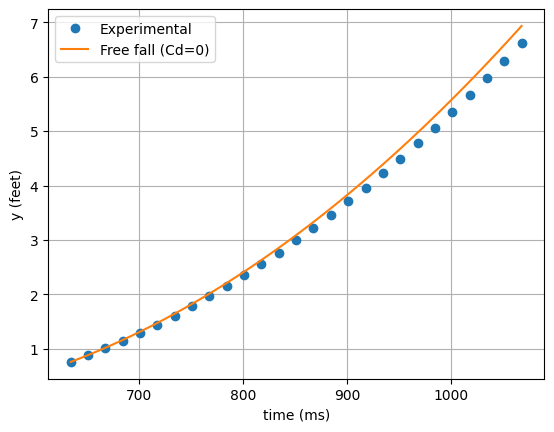

In [ ]:
plt.plot(df['time'], df['y'], 'o', label='Experimental')
plt.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.legend()
plt.grid(True)

In [ ]:
from scipy.optimize import minimize

def cost_function(Cd, df, y0, v0, m, r):
    """
    Calculate how well a given Cd matches the experimental data.
    Returns the sum of squared errors between predicted and actual y positions.
    """
    # Get time span from data
    t_start = df['time'].min() / 1000
    t_end = df['time'].max() / 1000
    
    # Run simulation with this Cd value
    sol = simulate_trajectory((t_start, t_end), y0, v0, m, r, Cd=Cd[0])
    
    # Get predicted y values at experimental time points
    t_exp = df['time'].values / 1000  # experimental times in seconds
    y_pred = sol.sol(t_exp)[0]  # interpolate solution at these times
    
    # Calculate sum of squared errors
    y_exp = df['y'].values
    error = np.sum((y_pred - y_exp)**2)
    
    return error

In [ ]:
result = minimize(cost_function, x0=[0.5], args=(df, y0, v0, m, r), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.8305176563671355


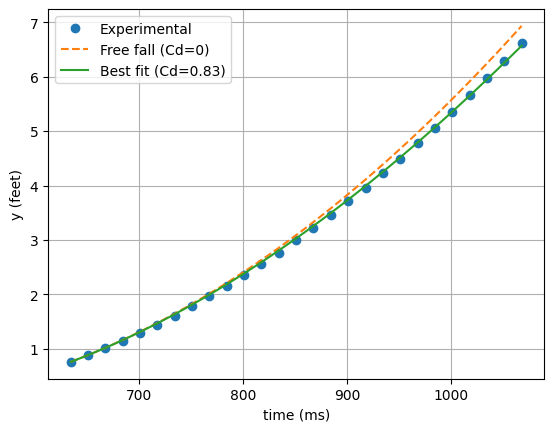

In [ ]:
# Run simulation with best Cd
sol_best = simulate_trajectory((t_start, t_end), y0, v0, m, r, Cd=best_Cd)

# Plot comparison
plt.plot(df['time'], df['y'], 'o', label='Experimental')
plt.plot(sol.t * 1000, sol.y[0], '--', label='Free fall (Cd=0)')
plt.plot(sol_best.t * 1000, sol_best.y[0], '-', label=f'Best fit (Cd={best_Cd:.2f})')
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.legend()
plt.grid(True)

## Graphic comparison free fall, experimental, curve fit to calculated Cd (coeff of drag)

In [ ]:
result = minimize(cost_function, x0=[0.5], args=(df, y0, v0, m, r), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.8305176563671355


The CoD is proportional to speed, right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Not quite! The **drag force** is proportional to velocity squared (v²), not just velocity. That's why in the equation of motion we have:

$$F_{drag} = \frac{1}{2} C_d \rho A v^2$$

The **coefficient of drag (Cd)** itself is actually a constant property of the object's shape - it doesn't change with speed (at least for typical speeds where the flow regime stays the same).

So to clarify:
- **Cd** = constant (depends on shape, surface roughness)
- **Drag force** = proportional to v²

That's why air resistance has such a big effect at higher speeds - if you double the speed, the drag force quadruples!

Does that make sense? Do you want to explore how the drag force changes with velocity in your data?

That was what I meant. OK. So it would be nice to show that graphically.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! You could plot the drag force versus velocity to see that quadratic relationship.

You'll need to:
1. Calculate the drag force at each point using your best Cd value
2. Plot drag force vs velocity

Try something like:

```python
# Calculate drag force from your experimental data
A = np.pi * (r/12)**2  # area in ft²
rho = 0.0765  # lb/ft³
```

Would you like to finish writing the calculation and make the plot, or would you like me to write it for you?

I was thinking that from F = ma, that the accleration would be proportional to v^2. But, only the acceleration due to drag is. That is why a couple of my charts made no sense.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! You've got it. The **total** acceleration is:

$$a_y = g - \frac{C_d \rho A}{2m} v_y^2$$

So it's:
- **Constant part**: g (gravity, always pulling down)
- **Velocity-dependent part**: the drag term (proportional to v², opposing motion)

That's why your acceleration vs. velocity scatter plot looked messy - the total acceleration includes both effects, and they work against each other.

If you want to see the v² relationship clearly, you'd need to plot just the **drag acceleration** (which is `g - ay`) versus velocity. Want to try making that plot?

Yes.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! To plot drag acceleration vs velocity, you'll need to:

1. Calculate the drag acceleration: `a_drag = g - ay` (where ay is your experimental acceleration)
2. Plot `a_drag` versus `vy`

Try writing that code. Remember that g = 32.174 ft/s².

What do you expect the relationship to look like?

<Axes: xlabel='vy_squared'>

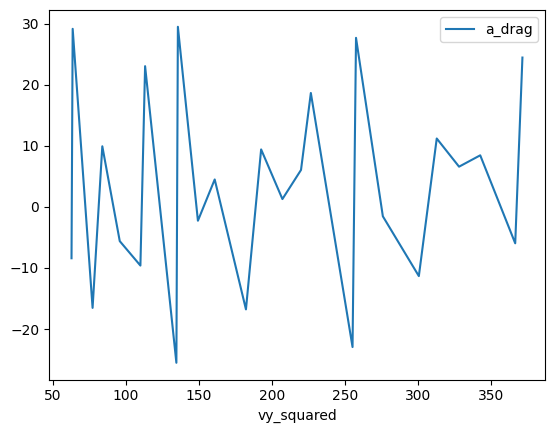

In [ ]:
df['vy_squared'] = df.vy * df.vy
df['a_drag'] = 32.174 - df['ay']
df.plot(x='vy_squared', y='a_drag')

## Would a polyfit curve fitting help here?

Fitted k = 0.0163


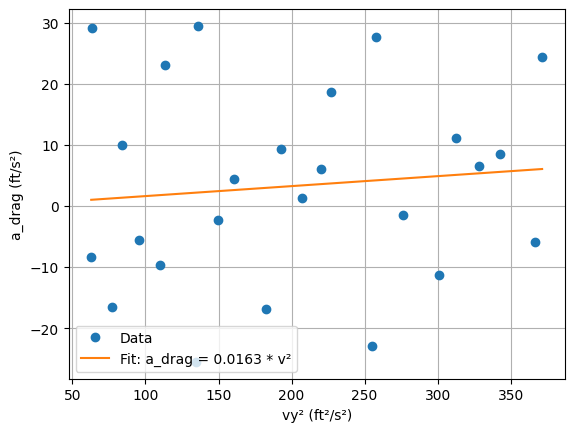

In [ ]:
# Remove NaN values
mask = df['vy_squared'].notna() & df['a_drag'].notna()
vy2_clean = df.loc[mask, 'vy_squared']
adrag_clean = df.loc[mask, 'a_drag']

# Fit line through origin: a_drag = k * vy_squared
k = np.sum(vy2_clean * adrag_clean) / np.sum(vy2_clean**2)

# Plot data and fit
plt.plot(vy2_clean, adrag_clean, 'o', label='Data')
plt.plot(vy2_clean, k * vy2_clean, '-', label=f'Fit: a_drag = {k:.4f} * v²')
plt.xlabel('vy² (ft²/s²)')
plt.ylabel('a_drag (ft/s²)')
plt.legend()
plt.grid(True)

print(f"Fitted k = {k:.4f}")

Please pop that equation back up here. I want to look at it to figure out the role `k` plays versus the drag parameter part of the equation.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the equation of motion with drag:

$$a_y = g - \frac{C_d \rho A}{2m} v_y^2$$

So the drag acceleration is:

$$a_{drag} = g - a_y = \frac{C_d \rho A}{2m} v_y^2$$

This means your fitted `k` value should equal:

$$k = \frac{C_d \rho A}{2m}$$

You can solve for Cd from k:

$$C_d = \frac{2mk}{\rho A}$$

Want to calculate what Cd value this k gives you and compare it to the 0.83 you got from the trajectory fitting?

In [ ]:
m_lb = m / 453.592     # convert grams to pounds
A = np.pi * (r/12)**2  # area in ft²
rho = 0.0765           # lb/ft³
cd_from_raw_data = 2 * m_lb * k / rho / A
print(f"Coefficient of drag using the raw and derived data {cd_from_raw_data:.3f}")

Coefficient of drag using the raw and derived data 0.486


In [ ]:
A, rho, m_lb, k

(np.float64(0.05176937465154365),
 0.0765,
 0.05886347201890686,
 np.float64(0.016344144236202597))

That is still a pretty big difference. Is that all explained by using the average of v, between the initial condition and the 2nd position, like for a...

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're thinking about the numerical differentiation issue - yes, that's part of it! When you calculate velocity and acceleration using `diff()`, you're getting approximate values at intermediate points, which introduces errors.

But there are other sources of error too:

1. **Noise amplification**: The acceleration is the second derivative, so measurement errors in position get amplified twice
2. **Timing precision**: Small errors in frame timing affect velocity and acceleration calculations
3. **The scatter**: Look at how noisy your a_drag vs v² plot is - lots of variation around the fitted line

The trajectory fitting method (Cd ≈ 0.83) is generally more robust because it uses the entire trajectory and integrates the equations forward, which tends to smooth out noise. The direct calculation from accelerations (Cd ≈ 0.49) is more sensitive to measurement noise.

Which method do you think is more reliable given what you see in your data?

## I feel like assigning the velocity at t0 equal to the average velocity between t0 and t1 is wrong.
I feel like the original fit was a better approach. That said, how sensitive is that to v0? 

Should we start with
- x0 = x1 (0.88) 
- v0 = (x2 - x0) / (t2 -t0)?

I was thinking 
```
t0 = df.time.iloc[1]
y0 = df['y'].iloc[1]
vy0 = (df['y'].iloc[0] - df['y'].iloc[2]) / (df['time'].iloc[0] - df['time'].iloc[2]) * 1000
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

That's a clever approach - using a centered difference (point 0 to point 2) to estimate velocity at point 1. This can be more accurate than a forward difference!

One small issue: you have the signs backwards. Since y increases with time (ball is falling), you want:

```python
vy0 = (df['y'].iloc[2] - df['y'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
```

Try setting up those initial conditions and rerunning the optimization. Does the Cd value change significantly?

In [ ]:
y0  = df['y'].iloc[1]
vx0 = (df['x'].iloc[2] - df['x'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
vy0 = (df['y'].iloc[2] - df['y'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
t0  = df.time.iloc[1] /1000   # convert to seconds
t_end = df['time'].max() / 1000
v0 = (vx0, vy0)

In [ ]:
print(f"y0 {y0:.2f}\nvx0 {vx0:.2f}\nvy0 {vy0:.2f}\nt0 {t0:.2f}\nt_end {t_end:.2f}\nv0 {v0}")

y0 0.88
vx0 -0.26
vy0 7.59
t0 0.65
t_end 1.07
v0 (np.float64(-0.26359298857982033), np.float64(7.589330722829077))


In [ ]:
sol = simulate_trajectory((t0, t_end), y0, v0, m, r, Cd=0)

## cost-prime
We need to change the cost function because we changed the start time, which was wired in.

In [ ]:
from scipy.optimize import minimize

def cost_function_prime(Cd, df, y0, v0, m, r):
    """
    Calculate how well a given Cd matches the experimental data.
    Returns the sum of squared errors between predicted and actual y positions.
    """
    # Get time span from data
    # t_start = df['time'].min() / 1000
    t_end = df['time'].max() / 1000
    
    # Run simulation with this Cd value
    sol = simulate_trajectory((t0, t_end), y0, v0, m, r, Cd=Cd[0])
    
    # Get predicted y values at experimental time points
    t_exp = df['time'].values / 1000  # experimental times in seconds
    y_pred = sol.sol(t_exp)[0]  # interpolate solution at these times
    
    # Calculate sum of squared errors
    y_exp = df['y'].values
    error = np.sum((y_pred - y_exp)**2)
    
    return error

In [ ]:
result = minimize(cost_function_prime, x0=[0.5], args=(df, y0, v0, m, r), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.5935019823912558


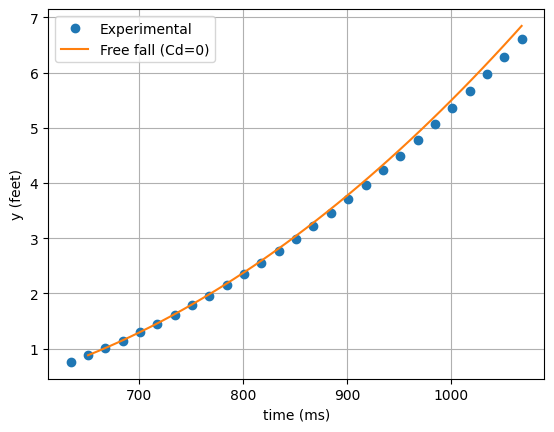

In [ ]:
plt.plot(df['time'], df['y'], 'o', label='Experimental')
plt.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.legend()
plt.grid(True)

## Final improved calculation of Cd

In [ ]:
df_fit = df.iloc[1:]
result = minimize(cost_function_prime, x0=[0.5], args=(df_fit, y0, v0, m, r), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.5935024721191245


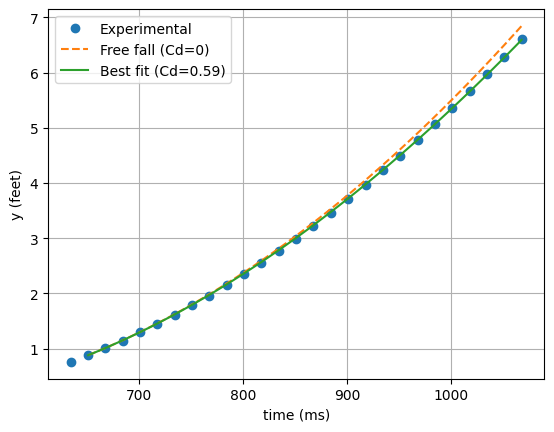

In [ ]:
# Run simulation with new best Cd
sol_best = simulate_trajectory((t0, t_end), y0, v0, m, r, Cd=best_Cd)

# Plot all three
plt.plot(df['time'], df['y'], 'o', label='Experimental')
plt.plot(sol.t * 1000, sol.y[0], '--', label='Free fall (Cd=0)')
plt.plot(sol_best.t * 1000, sol_best.y[0], '-', label=f'Best fit (Cd={best_Cd:.2f})')
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.legend()
plt.grid(True)

To do: Rework the Cd calculation using 2-D. Only 1 camera, but we can include the x, vx part of the equation of motion.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! Including the x-dimension should give you a more accurate Cd since you'll be fitting to the full 2D trajectory.

You'll need to modify `simulate_trajectory` to handle both x and y dimensions. The key changes:

1. The state vector becomes `[x, y, vx, vy]` instead of just `[y, vy]`
2. The total velocity magnitude is `v = sqrt(vx² + vy²)`
3. Drag acts opposite to velocity in both directions

The equations become:
$$a_x = -k v_x |v|$$
$$a_y = g - k v_y |v|$$

where $|v| = \sqrt{v_x^2 + v_y^2}$

Want to try modifying the function, or would you like me to write it for you?

I want to include a ball object in the call. How about a dataclass for the ball?
- Area, m  with convenience functions like from grams, oz, There will be variations between brands.

2.D.3 Size. The ball shall be 2.87 inches (7.29 cm) to
2.97 inches (7.54 cm) in diameter. The maximum
out-of-round diameter variance shall not be
greater than +/-0.020 inch (0.51 mm).

2.D.4 Weight. The ball shall weigh between 0.78 and
0.935 ounces (22.1 and 26.5 grams).

2.D.5 Bounce. The ball shall have a bounce of 30 to 
 USA PICKLEBALL EQUIPMENT STANDARDS MANUAL (Jan 2025) 6
34 inches (76.2 to 86.4 cm) to the top of the
ball when dropped from a height of 78 inches
(198.1 cm) onto a granite surface plate that is
a minimum of 12 inches (30.5 cm) by 12 inches
(30.5 cm) by 4 inches (10.2 cm). The test is to
be performed at an ambient temperature of 70
degrees F plus or minus 5 degrees F.

2.D.6 Compression. The ball, undergoing a test performed in accordance with (IAW) ASTM F1888-
09, shall yield an average compression test
result of <43 LBF. Each ball will be tested two (2)
times, once with the load applied perpendicular
to the ball seam (if applicable) and once with
the load applied parallel to the ball seam (if
applicable). If there are no seams, then the
ball will be tested once in a random location
and the second location will be approximately
90-degrees from the first.

- physical_constants, g, rho, create using sea level, STP, humidity, with normal defaults. 



In [ ]:
def simulate_trajectory_2d(t_span, r0, v0, env, ball, Cd=0):
    """
    Simulate 2D pickleball trajectory with air resistance.
    
    Parameters:
    - t_span: (t_start, t_end) in seconds
    - r0: initial position [x0, y0] in feet
    - v0: initial velocity [vx0, vy0] in ft/s
    - m: mass in grams
    - r_ball: radius in inches
    - Cd: coefficient of drag (default 0 for free fall)
    
    Returns: solution object from solve_ivp
    """
    from scipy.integrate import solve_ivp
    
    # Constants
    g = np.array([0, env.g_ft_s2])
    rho = env.rho_lb_ft3
    m_lb = ball.mass_lb
    A = ball.area_ft2
    
    # Drag coefficient term
    k = 0.5 * Cd * rho * A / m_lb if Cd > 0 else 0
    
    def derivatives(t, state):
        # state = [x, y, vx, vy]
        r = state[:2]
        v = state[2:]
        
        # Calculate acceleration
        v_mag = np.linalg.norm(v)
        a_drag = -k * v * v_mag if v_mag > 0 else np.array([0, 0])
        a = g + a_drag
        
        return np.concatenate([v, a])
    
    # Initial state: [x0, y0, vx0, vy0]
    state0 = np.concatenate([r0, v0])
    
    # Solve ODE
    sol = solve_ivp(derivatives, t_span, state0, 
                    dense_output=True, max_step=0.01)
    
    return sol

## 2-D initial conditions

In [ ]:
y0  = df['y'].iloc[1]
vx0 = 1.8 * (df['x'].iloc[2] - df['x'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
vy0 = (df['y'].iloc[2] - df['y'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
t0  = df.time.iloc[1] /1000   # convert to seconds
t_end = df['time'].max() / 1000
v0 = (vx0, vy0)
t_span = (t0, t_end)
r0 = (df.x.iloc[1], df.y.iloc[1])
v0 = (vx0, vy0)
ball = Pickleball(26.7, 2.9375/2)
env = Environment()
sol = simulate_trajectory_2d(t_span, r0, v0, env, ball, Cd=0)

I guess I need to change plot to match the new sol. Perhaps side by side x, y

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! The 2D solution has a different structure. Now `sol.y` has 4 rows:
- `sol.y[0]` = x positions
- `sol.y[1]` = y positions  
- `sol.y[2]` = vx velocities
- `sol.y[3]` = vy velocities

For side-by-side plots, you could use:

```python
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
```

Want to try creating the two subplots showing x vs time and y vs time?

yes, for the solution and the experimental

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Try something like this structure:

```python
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: x vs time
ax1.plot(df['time'], df['x'], 'o', label='Experimental')
ax1.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
```

Can you complete it by adding the y vs time plot on `ax2` and adding labels/legends to both?

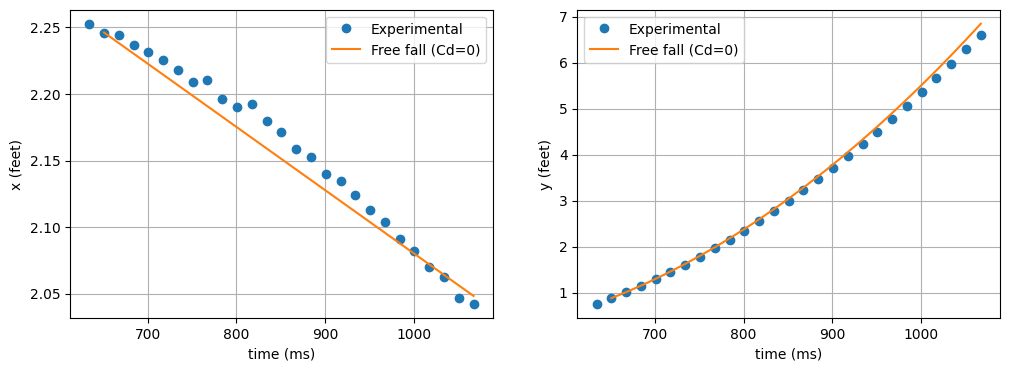

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: x vs time
ax1.plot(df['time'], df['x'], 'o', label='Experimental')
ax1.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('x (feet)')
ax1.legend()
ax1.grid(True)


# Right plot: y vs time
ax2.plot(df['time'], df['y'], 'o', label='Experimental')
ax2.plot(sol.t * 1000, sol.y[1], '-', label='Free fall (Cd=0)')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('y (feet)')
ax2.legend()
ax2.grid(True)


That looks very funky. But, I think it goes away when we fit with a good Cd. This is a great look.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! The free fall model (Cd=0) doesn't account for air resistance, so:
- The **x-direction** shows the ball drifting too far (no drag to slow the horizontal motion)
- The **y-direction** shows the ball falling too fast (no drag opposing gravity)

Now you're ready to fit for the best Cd using both x and y data. You'll need to:

1. Create a new cost function that compares both x and y positions
2. Run the optimization

Want to try writing the 2D cost function, or would you like me to write it for you?

## 2-D Cost function

In [ ]:
def cost_function_2d(Cd, df, r0, v0, env, ball, t0):
    """
    Calculate how well a given Cd matches the 2D experimental data.
    Returns the sum of squared errors for both x and y positions.
    """
    t_end = df['time'].max() / 1000
    
    # Run 2D simulation with this Cd value
    sol = simulate_trajectory_2d((t0, t_end), r0, v0, env, ball, Cd=Cd[0])
    
    # Get predicted positions at experimental time points
    t_exp = df['time'].values / 1000
    x_pred = sol.sol(t_exp)[0]
    y_pred = sol.sol(t_exp)[1]
    
    # Calculate sum of squared errors for both dimensions
    x_exp = df['x'].values
    y_exp = df['y'].values
    error = np.sum((x_pred - x_exp)**2 + (y_pred - y_exp)**2)
    
    return error
    

In [ ]:
result = minimize(cost_function_2d, x0=[0.5], args=(df, r0, v0, env, ball, t0), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.6520551104307886


In [ ]:
sol_best = simulate_trajectory_2d((t0, t_end), r0, v0, env, ball, Cd=best_Cd)


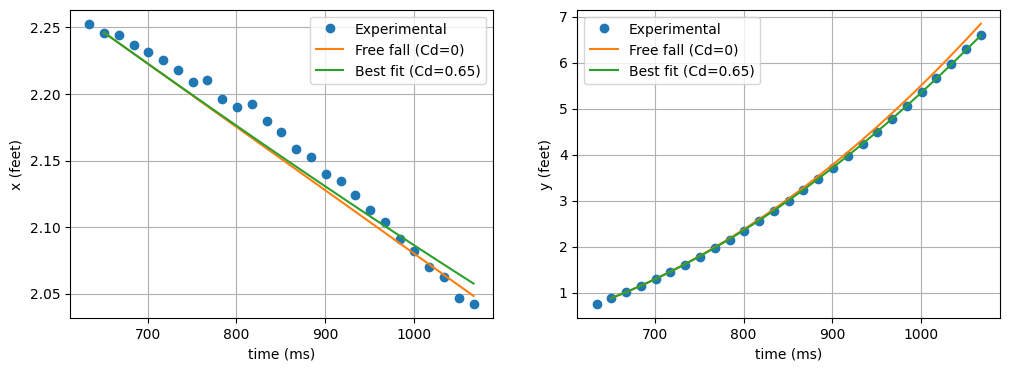

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: x vs time
ax1.plot(df['time'], df['x'], 'o', label='Experimental')
ax1.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
ax1.plot(sol_best.t * 1000, sol_best.y[0], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('x (feet)')
ax1.legend()
ax1.grid(True)

# Right plot: y vs time
ax2.plot(df['time'], df['y'], 'o', label='Experimental')
ax2.plot(sol.t * 1000, sol.y[1], '-', label='Free fall (Cd=0)')
ax2.plot(sol_best.t * 1000, sol_best.y[1], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('y (feet)')
ax2.legend()
ax2.grid(True)

## 2-D results

## Visualize drag adjusted plot in both x and y.
One thing that seems to be clear is that the x data is "noisier" than the y. You can even see the ball
drift back to the right twice. This is likely due to video artifacts. Lighting might be causing x-location
to err at different points in its trajectory. Likewise the higher speed component way may actually make 
centering the ball more consistent.

### Important note
This result multiplied the initial measured velocity by 1.8.

I was also going to review whether the 2D versions of simulate_trajectory and cost_function would just handle 1-D. It seems like it should.
The cost_function_prime was just a hack put in to handle starting at the second time point. I think that is better and plan to 
delete the original. But it is my hope that I can just use the _2d version for 1-D as well

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! The 2D versions should handle 1D cases naturally. If you pass in:
- `r0 = [x0, y0]` with `x0 = 0`
- `v0 = [0, vy0]` 

Then the x-component should just stay at zero (or very close with numerical precision), and you'd get the same 1D behavior.

Want to test it quickly? You could run `simulate_trajectory_2d` with `v0 = [0, vy0]` and see if `sol.y[0]` (the x positions) stays essentially constant.

Sure. Please set that up for me.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

```python
# Test 1D case using 2D function
r0_1d = [0, 0.88]  # x=0, y from your data
v0_1d = [0, 7.59]  # vx=0, vy from your data

sol_1d_test = simulate_trajectory_2d((t0, t_end), r0_1d, v0_1d, env, ball, Cd=0.65)

# Check if x stays at zero
print(f"x range: {sol_1d_test.y[0].min():.6f} to {sol_1d_test.y[0].max():.6f}")
print(f"Max x deviation: {np.abs(sol_1d_test.y[0]).max():.10f}")

# Plot to visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(sol_1d_test.t * 1000, sol_1d_test.y[0])
plt.xlabel('time (ms)')
plt.ylabel('x (feet)')
plt.title('X position (should be ~0)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sol_1d_test.t * 1000, sol_1d_test.y[1])
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.title('Y position')
plt.grid(True)
plt.tight_layout()
```

This will show you whether the 2D function handles the 1D case properly!

x range: 0.000000 to 0.000000
Max x deviation: 0.0000000000


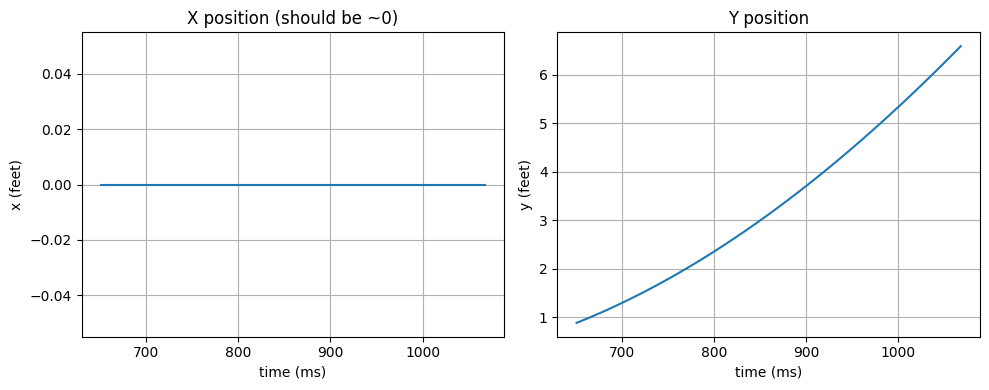

In [ ]:
# Test 1D case using 2D function
r0_1d = [0, 0.88]  # x=0, y from your data
v0_1d = [0, 7.59]  # vx=0, vy from your data

sol_1d_test = simulate_trajectory_2d((t0, t_end), r0_1d, v0_1d, env, ball, Cd=0.65)

# Check if x stays at zero
print(f"x range: {sol_1d_test.y[0].min():.6f} to {sol_1d_test.y[0].max():.6f}")
print(f"Max x deviation: {np.abs(sol_1d_test.y[0]).max():.10f}")

# Plot to visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(sol_1d_test.t * 1000, sol_1d_test.y[0])
plt.xlabel('time (ms)')
plt.ylabel('x (feet)')
plt.title('X position (should be ~0)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sol_1d_test.t * 1000, sol_1d_test.y[1])
plt.xlabel('time (ms)')
plt.ylabel('y (feet)')
plt.title('Y position')
plt.grid(True)
plt.tight_layout()

1. Interestingly enough, it is not mentioned in the rules, last I read carefully, whether the 78 inches is a measure to the bottom of the ball.
2. Is something that I have modeled separately, using assumed Cd and CoR. Magnus effect also simulated with no empirical measures of coefficients. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Interesting point about the 78" measurement! The official spec says "dropped from a height of 78 inches" but doesn't specify whether that's to the bottom, center, or top of the ball. Given it's measuring bounce "to the top of the ball," there's some ambiguity there.

For your bounce modeling with assumed Cd and CoR - are you planning to use your newly measured Cd (≈0.65) in those simulations now? That should make them more accurate than using literature values.

What's your priority: refining the drop test measurement first, or organizing the code into the package structure?

## 1-D repeated using `ballphysics` package

In [ ]:
from ballphysics.models import Pickleball, Environment
from ballphysics.analysis.tracking import simulate_trajectory_2d
from ballphysics.analysis.regression import cost_function_2d

In [ ]:
y0  = df['y'].iloc[1]
vx0 = 1.8 * (df['x'].iloc[2] - df['x'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
vy0 = (df['y'].iloc[2] - df['y'].iloc[0]) / (df['time'].iloc[2] - df['time'].iloc[0]) * 1000
t0  = df.time.iloc[1] /1000   # convert to seconds
t_end = df['time'].max() / 1000
v0 = (vx0, vy0)
t_span = (t0, t_end)
r0 = (df.x.iloc[1], df.y.iloc[1])
v0 = (vx0, vy0)
ball = Pickleball(26.7, 2.9375/2)
env = Environment()
sol = simulate_trajectory_2d(t_span, r0, v0, env, ball, Cd=0)

In [ ]:
# Test 1D case using 2D function
r0_1d = [0, 0.88]  # x=0, y from your data
v0_1d = [0, 7.59]  # vx=0, vy from your data

sol_1d_test = simulate_trajectory_2d((t0, t_end), r0_1d, v0_1d, env, ball, Cd=0.65)

result = minimize(cost_function_2d, x0=[0.5], args=(df, r0_1d, v0_1d, env, ball, t0), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

Best fit Cd = 0.6488354854443535


x range: 0.000000 to 0.000000
Max x deviation: 0.0000000000


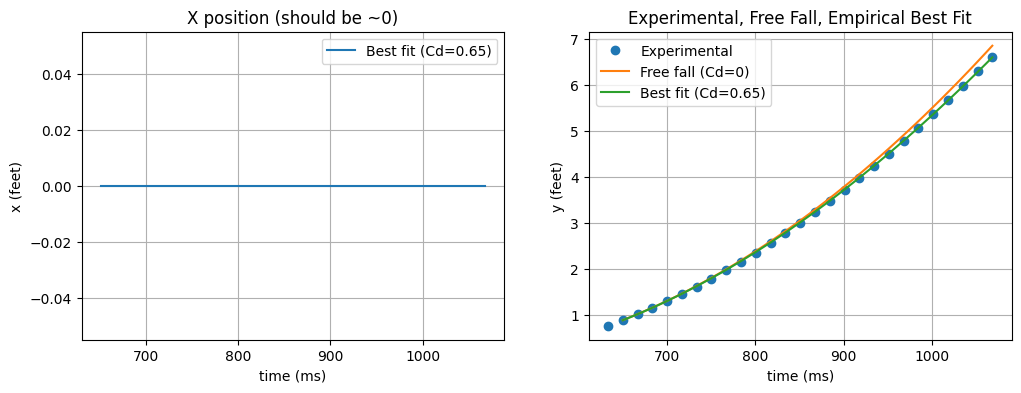

In [ ]:
# Check if x stays at zero
print(f"x range: {sol_1d_test.y[0].min():.6f} to {sol_1d_test.y[0].max():.6f}")
print(f"Max x deviation: {np.abs(sol_1d_test.y[0]).max():.10f}")

ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: x vs time
ax1.plot(sol_1d_test.t * 1000, sol_1d_test.y[0], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('x (feet)')
ax1.set_title('X position (should be ~0)')
ax1.legend()
ax1.grid(True)

# Right plot: y vs time
ax2.plot(df['time'], df['y'], 'o', label='Experimental')
ax2.plot(sol.t * 1000, sol.y[1], '-', label='Free fall (Cd=0)')
ax2.plot(sol_1d_test.t * 1000, sol_1d_test.y[1], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('y (feet)')
ax2.set_title('Experimental, Free Fall, Empirical Best Fit')
ax2.legend()
ax2.grid(True)

## 2-D repeated using `ballphysics` package

Best fit Cd = 0.6520551104307886


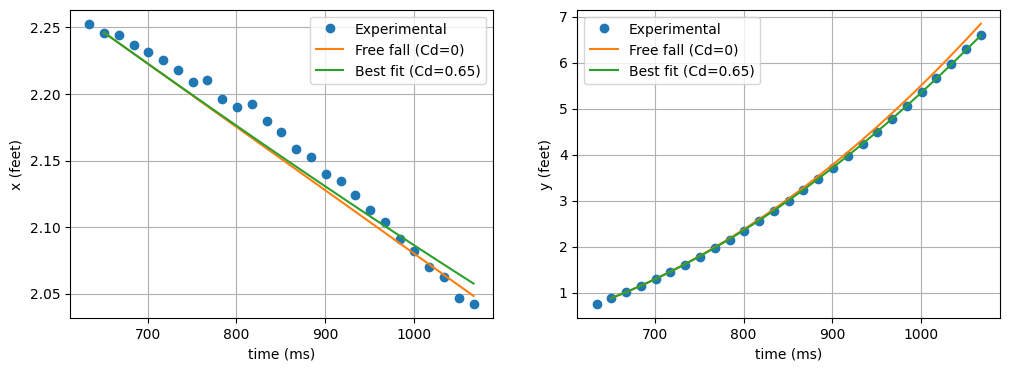

In [ ]:
result = minimize(cost_function_2d, x0=[0.5], args=(df, r0, v0, env, ball, t0), bounds=[(0, 2)])
best_Cd = result.x[0]
print(f"Best fit Cd = {best_Cd}")

sol_best = simulate_trajectory_2d((t0, t_end), r0, v0, env, ball, Cd=best_Cd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: x vs time
ax1.plot(df['time'], df['x'], 'o', label='Experimental')
ax1.plot(sol.t * 1000, sol.y[0], '-', label='Free fall (Cd=0)')
ax1.plot(sol_best.t * 1000, sol_best.y[0], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('x (feet)')
ax1.legend()
ax1.grid(True)

# Right plot: y vs time
ax2.plot(df['time'], df['y'], 'o', label='Experimental')
ax2.plot(sol.t * 1000, sol.y[1], '-', label='Free fall (Cd=0)')
ax2.plot(sol_best.t * 1000, sol_best.y[1], '-', label=f'Best fit (Cd={best_Cd:.2f})')
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('y (feet)')
ax2.legend()
ax2.grid(True)